In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath("../src"))

from utils.LMU_Stack import LMUStack
import numpy as np
import nengo
from collections import deque

class IdealDelay(nengo.synapses.Synapse):
    def __init__(self, delay):
        super().__init__()
        self.delay = delay

    def make_state(self, shape_in, shape_out, dt, dtype=None, y0=None):
        return {}

    def make_step(self, shape_in, shape_out, dt, rng, state):
        # buffer the input signal based on the delay length
        buffer = deque([0] * int(self.delay / dt))

        def delay_func(t, x):
            buffer.append(x.copy())
            return buffer.popleft()

        return delay_func

In [4]:
f = 2
rms = 0.30
delay= 0.5
sim_t=50

with nengo.Network() as model:
    stim1 = nengo.Node(output=nengo.processes.WhiteSignal(high=f, period=sim_t, rms=rms, y0=0, seed=0))
    stim2 = nengo.Node(output=nengo.processes.WhiteSignal(high=f, period=sim_t, rms=rms, y0=0, seed=1))
    stim = nengo.Node(size_in=2)
    
    lmu_set = LMUStack(2, order=8)
    err_node = nengo.Node(lambda t, x: x if t < sim_t * 0.8 else 0, size_in=2)
    
    intermediate = nengo.Ensemble(2*8*100, 2*8)
    out = nengo.Ensemble(250, 2)

    nengo.Connection(stim1, stim[0])
    nengo.Connection(stim2, stim[1])

    nengo.Connection(stim, lmu_set.input)

    nengo.Connection(stim, err_node, synapse=IdealDelay(delay), transform=-1)
    nengo.Connection(out, err_node, synapse=0)
    nengo.Connection(lmu_set.output, intermediate)

    learn_conn = nengo.Connection(intermediate, out, function=lambda x: [0,0], learning_rule_type=nengo.PES(2e-4))
    nengo.Connection(err_node, learn_conn.learning_rule, synapse=None)

    p_stim = nengo.Probe(stim)
    p_out = nengo.Probe(out, synapse=0.05)


    
with nengo.Simulator(model, seed=0) as sim:
    sim.run(sim_t)

Build finished in 0:00:02.                                                      
Simulation finished in 0:00:16.                                                 


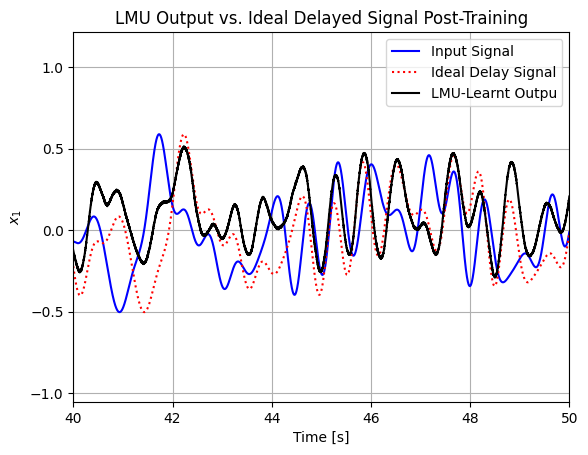

In [10]:
import matplotlib.pyplot as plt


plt.plot(sim.trange(), sim.data[p_stim][:,0], 'b', label="Input Signal")
plt.plot(sim.trange()+0.5, sim.data[p_stim][:,0], 'r:', label="Ideal Delay Signal")
plt.plot(sim.trange(), sim.data[p_out][:,0], 'k', label="LMU-Learnt Outpu")

plt.title("LMU Output vs. Ideal Delayed Signal Post-Training")
plt.xlabel("Time [s]")
plt.ylabel("$x_{1}$")
plt.xlim(40,50)
plt.legend()
plt.grid()